# Demo 2: a demo based on Haxby fMRI data
Here is a demo based on the publicly available Haxby fMRI datasets. (Reference: Haxby, J. V. (2001). Distributed and Overlapping Representations of Faces and Objects in Ventral Temporal Cortex. Science, 293(5539), 2425–2430.) Nilearn has been used to load this dataset and plot some results in this demo.

In [1]:
# -*- coding: utf-8 -*-

' a demo based on Haxby fMRI data '
# Users can learn how to use Neurora to do research based on fMRI data.

__author__ = 'Zitong Lu'

from nilearn import datasets, plotting
from nilearn.image import index_img, mean_img
import numpy as np
import pandas as pd
import nibabel as nib
from neurora.stuff import get_affine, datamask
from neurora.nps_cal import nps_fmri, nps_fmri_roi
from neurora.rsa_plot import plot_rdm
from neurora.rdm_cal import fmriRDM_roi, fmriRDM
from neurora.corr_cal_by_rdm import fmrirdms_corr
from neurora.nii_save import corr_save_nii

/Users/zitonglu/anaconda3/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Section 1: Loading example data
Here, we use Nilearn toolbox for loading data and processing. You can learn this process from Nilearn (http://nilearn.github.io/index.html).

In [2]:
# load Haxby dataset (here, we only use subject2's data for this example)
haxby_dataset = datasets.fetch_haxby()

# load the fMRI data filename & mask data filename
func_filename = haxby_dataset.func[0]
mask_filename = haxby_dataset.mask

# read label information of the experiment
labelinfo = pd.read_csv(haxby_dataset.session_target[0], sep=' ')
labels = labelinfo['labels']

## Section 2: Preprocessing

/Users/zitonglu/anaconda3/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


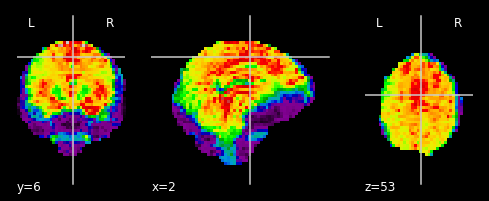

In [3]:
# get mask data NumPy array
maskdata = nib.load(mask_filename).get_fdata()

# get the size of the data
nx, ny, nz = maskdata.shape

# labels of seven ategories
categories = ["face", "cat", "house", "chair", "shoe", "bottle", "scissors"]
# numbe of conidtions: 7
ncon = len(categories)

# get fmri data under 7 conditions
# here we average the data under different conditions
fmri_data = np.full([ncon, nx, ny, nz], np.nan)

for i in range(ncon):
    img = mean_img(index_img(func_filename, labels.isin([categories[i]])))
    fmri_data[i] = datamask(img.get_fdata(), maskdata)

# get fmri data under 'face'-condition
face_img = nib.Nifti1Image(fmri_data[0], affine=img.affine)
# have a look
plotting.plot_epi(face_img)
plotting.show()

# reshaoe the data: [ncon, nx, ny, nz] -> [ncon, nsubs, nx, ny, nz]
# here just one subject's data
fmri_data = np.reshape(fmri_data, [ncon, 1, nx, ny, nz])

## Section 3: Calculating the neural pattern similarity (for ROI)

In [4]:
# get mask of 'mask_face' in the dataset
mask_face_filename = haxby_dataset.mask_face[0]
mask_face_data = nib.load(mask_face_filename).get_fdata()

# get input data under two condition
# here, "face"-condition vs. "scissors"-condition
nps_fmri_data = fmri_data[[0, 6]]

# calculate the neural pattern similarity (NPS) for ROI between two stimulus
nps_roi = nps_fmri_roi(nps_fmri_data, mask_face_data)

# print the NPS result
print(nps_roi)


Computing NPS

Computing finished!
[[9.99448468e-01 5.88083954e-43]]


## Section 4: Calculating the neural pattern similarity (Searchlight)


Computing NPS
Calculating: [====================================================================================================] 100.00%alculating: [=================================                                                                   ] 33.83%Calculating: [=======================================================================                             ] 71.27%Calculating: [========================================================================================            ] 88.08%
Computing finished!
demo2_nps_img.nii
Save RSA results.
File(demo2_nps_img.nii) saves successfully!


/Users/zitonglu/anaconda3/lib/python3.7/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  "Non-finite values detected. "


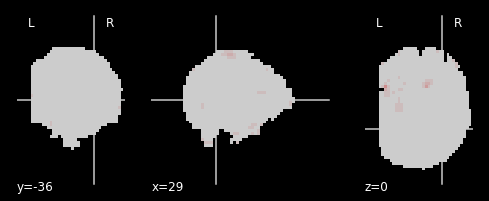

In [5]:
# calculate the neural pattern similarity (NPS) between two stimulus
nps = nps_fmri(nps_fmri_data)

# convert the NPS results into a .nii file
savefilename = "demo2_nps_img"
affine = get_affine(mask_filename)
corr_save_nii(nps[0], filename=savefilename, affine=affine, size=[nx, ny, nz], smooth=False, plotrlt=False)

# have a look
plotting.plot_epi(savefilename+".nii")
plotting.show()

## Section 5: Calculating the RDM for ROI and Plotting


Computing RDMs

RDMs computing finished!
1


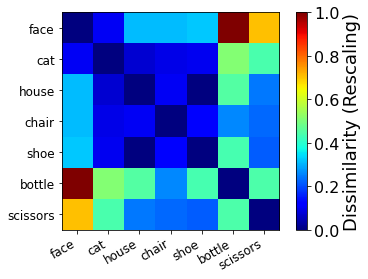

0

In [12]:
# get mask of "mask_vt" in the dataset
mask_vt_filename = haxby_dataset.mask_face[0]
mask_vt_data = nib.load(mask_vt_filename).get_fdata()

# calculate the RDM for ROI
rdm_roi = fmriRDM_roi(fmri_data, mask_vt_data, abs=False)[0]

# plot the RDM
plot_rdm(rdm_roi, rescale=True, conditions=categories)

## Section 6: Calculating the RDM by Searchlight and Plotting


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!
1


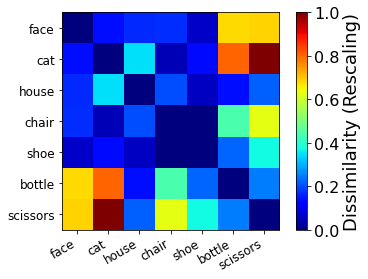

0

In [13]:
# calculate the RDMs by Searchlight
fmri_RDMs = fmriRDM(fmri_data, sub_opt=0)

# plot one of the RDMs
plot_rdm(fmri_RDMs[20, 30, 30], rescale=True, conditions=categories)

## Section 7: Calculating the representational similarities between a coding model and neural activities 

1


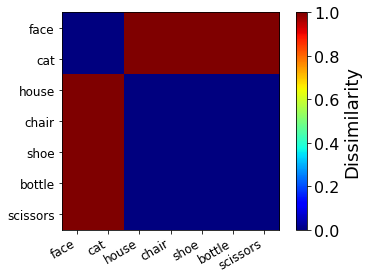


Computing similarities
Calculating: [====================================================================================================] 100.00%alculating: [============================================                                                        ] 44.88%Calculating: [====================================================                                                ] 52.47%Calculating: [=======================================================                                             ] 55.16%Calculating: [================================================================                                    ] 64.20%Calculating: [====================================================================                                ] 68.05%
Computing finished!


In [14]:
# Create a RDM for "animate-inanimate" coding model
# which means the representations of animate matters are highly similar
# and the representations of inanimate matters are highly similar
model_RDM = np.array([[0, 0, 1, 1, 1, 1, 1],
                      [0, 0, 1, 1, 1, 1, 1],
                      [1, 1, 0, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0]])

# plot the model RDM
plot_rdm(model_RDM, conditions=categories)

# calculate the similarities between model RDM and searchlight RDMs
corrs = fmrirdms_corr(model_RDM, fmri_RDMs)

## Section 8: Saving the RSA result and Plotting

Cluster-wise FDR correction
Correcting: [====================================================================================================] 100.00%

finished Cluster-wise FDR correction
demo2_rsarlt_img.nii
Save RSA results.
File(demo2_rsarlt_img.nii) saves successfully!
Plot RSA results.


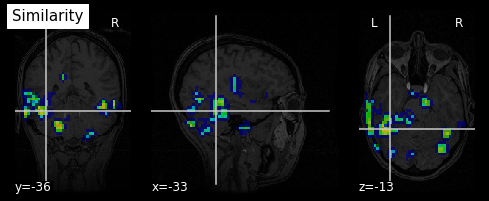

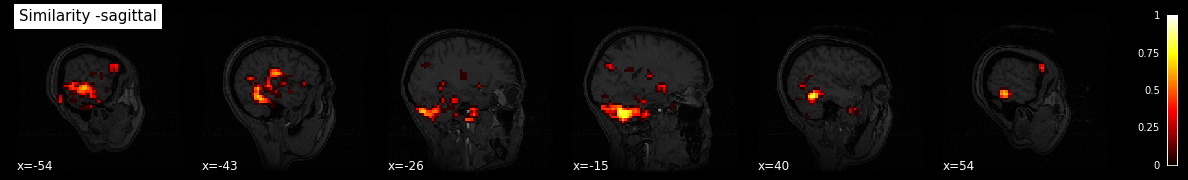

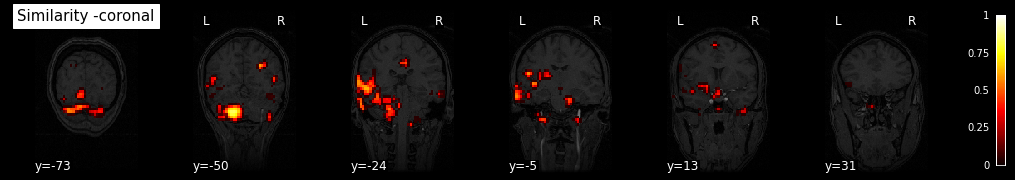

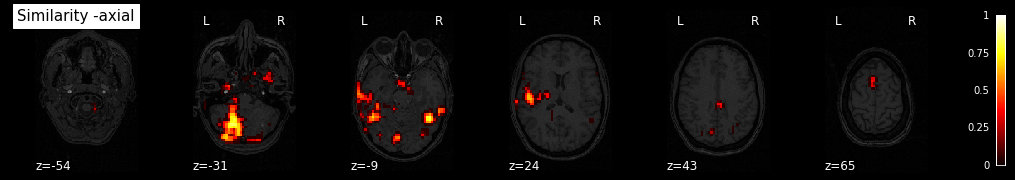

/Users/zitonglu/anaconda3/lib/python3.7/site-packages/nilearn/plotting/surf_plotting.py:215: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  xlim=limits, ylim=limits)


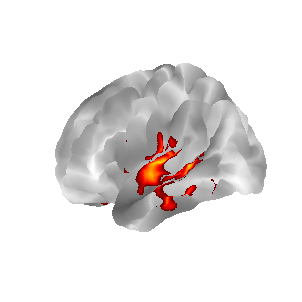

In [ ]:
# load the filename of anatomical image as the background for plotting
ant_filename = haxby_dataset.anat[0]

# get the affine info
affine = get_affine(mask_filename)

# save the RSA result as a .nii file
# and visualize the result automatically
# p < 0.05, FDR-correct
rsarltfilename = "demo2_rsarlt_img.nii"
img = corr_save_nii(corrs, filename=rsarltfilename, affine=affine, corr_mask=mask_filename, size=[40, 64, 64], p=0.05, correct_method="Cluster-FDR", plotrlt=True, img_background=ant_filename)

# Users can plot the RSA results independently by functions below
from neurora.rsa_plot import plot_brainrsa_regions
from neurora.rsa_plot import plot_brainrsa_montage
from neurora.rsa_plot import plot_brainrsa_glass
from neurora.rsa_plot import plot_brainrsa_surface

# here use a [5, 5, 5] cube to remove the significant area smaller than it
# before filtering
plot_brainrsa_montage(rsarltfilename, slice=[[-25], 0, 0], background=ant_filename)
# after filtering
plot_brainrsa_montage(rsarltfilename, threshold=125, slice=[[-25], 0, 0], background=ant_filename)